In [1]:
import pyccl as ccl
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.integrate import quad, dblquad
from scipy import interpolate

In [2]:
ccl.__version__

'3.2'

In [3]:
import pylab as pl

# Define cosmology, introduce functions

In [4]:
#Set up a cosmology
yourz=0.
h=0.67
H0=100*h
Omega_m=0.315
c_ls=300*10**3
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=Omega_m-0.27, h=h, A_s=2.1e-9, n_s=0.96)
a=1./(1+yourz)


def chi(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

def chi_3d(r,z):
    return ccl.correlations.correlation_3d(cosmo,1/(1+z),r,'delta_matter:delta_matter')

In [13]:
z=np.linspace(2,3,21)
comoving_d = chi(z)
print(z[1]-z[0])
print(comoving_d[1:]-comoving_d[:-1])

z=np.linspace(0,1,21)
comoving_d = chi(z)
print(z[1]-z[0])
print(comoving_d[1:]-comoving_d[:-1])

0.04999999999999982
[72.92691204 71.27930638 69.68973137 68.15442473 66.67263639 65.24062348
 63.85639215 62.5187827  61.22517114 59.97354937 58.76223818 57.58960077
 56.45404919 55.35404974 54.28812762 53.25487126 52.25293626 51.28104949
 50.33801313 49.42270924]
0.05
[221.05796531 215.64054125 210.13027703 204.56562694 198.98227221
 193.41256979 187.88506933 182.42478076 177.05298935 171.78697325
 166.64127338 161.62686953 156.75197022 152.02280398 147.44297968
 143.0146268  138.73815814 134.61297072 130.63716685 126.80796032]


Power spectrum $P(l,z)=P_{\delta}(k=\frac{l+1/2}{\chi(z)},z)$

In [5]:
def PNL(l,z):
    #return ccl.power.nonlin_matter_power(cosmo, k=(l+0.5)/chi(z), a=1/(1+z))
    return ccl.power.nonlin_power(cosmo, k=(l+0.5)/chi(z), a=1/(1+z), p_of_k_a='delta_matter:delta_matter')

def Plin(l,z):
    #return ccl.power.linear_matter_power(cosmo, k=(l+0.5)/chi(z), a=1/(1+z))
    return ccl.power.linear_power(cosmo, k=(l+0.5)/chi(z), a=1/(1+z), p_of_k_a='delta_matter:delta_matter')

In [8]:
help(ccl.correlations.correlation)

Help on function correlation in module pyccl.correlations:

correlation(cosmo, *, ell, C_ell, theta, type='NN', method='fftlog')
    Compute the angular correlation function.

    .. math::

        \xi^{ab}_\pm(\theta) =
        \sum_\ell\frac{2\ell+1}{4\pi}\,(\pm1)^{s_b}\,
        C^{ab\pm}_\ell\,d^\ell_{s_a,\pm s_b}(\theta)

    where :math:`\theta` is the angle between the two fields :math:`a` and
    :math:`b` with spins :math:`s_a` and :math:`s_b` after alignement of their
    tangential coordinate. :math:`d^\ell_{mm'}` are the Wigner-d matrices and
    we have defined the power spectra

    .. math::
        C^{ab\pm}_\ell \equiv
        (C^{a_Eb_E}_\ell \pm C^{a_Bb_B}_\ell)+i
        (C^{a_Bb_E}_\ell \mp C^{a_Eb_B}_\ell),

    which reduces to the :math:`EE` power spectrum when all :math:`B`-modes
    are 0.

    The different spin combinations are:

        * :math:`s_a=s_b=0` e.g. galaxy-galaxy, galaxy-:math:`\kappa`
          and :math:`\kappa`-:math:`\kappa`
        * :math

# 1- $\omega_{dm}$ Correlation

$\xi_{dm}(\theta,z)=\frac{H_0}{c}\frac{1}{\chi^2(z)}\sum_\ell \frac{2\ell+1}{4\pi} P_{\delta}(k=\frac{l+1/2}{\chi(z)},z) \mathcal{P}_{l}(\cos \theta)$

Then:
$\omega_{dm}(z)=\int d\theta W(\theta) \xi_{dm}(\theta,z)$. 

We procceed as follow:
- we generate the list $\{\ell\}$
-  we compute the associated angular power spectrum $P(k(l),z)$
- we use the correlation.correlation module to evaluate $\sum_{\ell}...$ given our power spectrum model
- we integrate it for our min-max projected scales (converted to angle) to have $\omega_{dm}$


### First with $r_p$ scale convention

In [10]:

def xi_dm_test(rp,z, typ):
    Hz=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+z))
    theta = rp/chi(z)*360/(2*math.pi)#in degree

    if typ=='linear':
        Plin_ell = [Plin(l,z) for l in Ell]
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,Ell,Plin_ell,theta,type='NN',method='Legendre')
    
    if typ=='NL':
        PNL_ell = [PNL(l,z) for l in Ell]
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,Ell,PNL_ell,theta,type='NN',method='Legendre')

def w_dm(z,typ):
    Hz=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+z))
    if typ=='linear':
        P_delta = [Plin(l,z) for l in Ell]
    if typ=='NL':
        P_delta = [PNL(l,z) for l in Ell]    
    
    #weight that should be normalised to unity
    def Wrp(rp):
        return rp**alpha
    norm=quad(Wrp,rp_min, rp_max,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]

    
    def xi_dm_int(rp):
    
        theta = rp/chi(z)*360/(2*math.pi)#in degree
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,ell=Ell,C_ell=P_delta,theta=theta,type='NN',method='Legendre')

    def Integ(rp):
        return Wrp(rp)/norm*xi_dm_int(rp)
    
    return quad(Integ,rp_min, rp_max,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]


In [11]:
Ell=range(1,4000)
nlim=10000
rp_min=1.5#Mpc! 
rp_max=5#Mpc!
alpha=0

Zlist=[0.625+0.05*i for i in range(8)]
W_dm_nl=[round(w_dm(z,typ='NL'),5) for z in Zlist] 
print(W_dm_nl)

[0.00893, 0.00871, 0.00851, 0.00832, 0.00814, 0.00796, 0.00781, 0.00766]


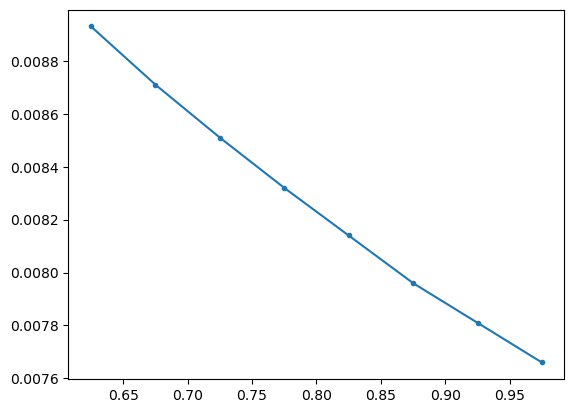

In [13]:
plt.plot(Zlist, W_dm_nl,'.-')

### Now for the $\theta$ scale convention:

In [16]:
def xi_dm_theta(theta,z, typ):
    Hz=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+z))
    #theta = rp/chi(z)*360/(2*math.pi)#in degree

    if typ=='linear':
        Plin_ell = [Plin(l,z) for l in Ell]
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,Ell,Plin_ell,theta,type='NN',method='Legendre')
    
    if typ=='NL':
        PNL_ell = [PNL(l,z) for l in Ell]
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,Ell,PNL_ell,theta,type='NN',method='Legendre')

def w_dm_theta(z,typ):
    Hz=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+z))
    if typ=='linear':
        P_delta = [Plin(l,z) for l in Ell]
    if typ=='NL':
        P_delta = [PNL(l,z) for l in Ell]    
    
    #weight that should be normalised to unity
    def Wtheta(theta):
        return theta**alpha
    norm=quad(Wtheta,theta_min, theta_max,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]
    
    
    def xi_dm_int(theta):
    
        #theta = rp/chi(z)*360/(2*math.pi)#in degree
        return Hz/c_ls/chi(z)**2*ccl.correlations.correlation(cosmo,ell=Ell,C_ell=P_delta,theta=theta,type='NN',method='Legendre')

    def Integ(theta):
        return Wtheta(theta)/norm*xi_dm_int(theta)
    
    return quad(Integ,theta_min, theta_max,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]


In [17]:
Ell=range(1,4000)
nlim=10000

theta_min=10/60 #deg
theta_max=30/60 #deg
alpha=0

Zlist=[0.625+0.05*i for i in range(8)]
W_dm_nl=[round(w_dm_theta(z,typ='NL'),5) for z in Zlist] 
print(W_dm_nl)

[0.00284, 0.00263, 0.00245, 0.00228, 0.00214, 0.00201, 0.0019, 0.00179]


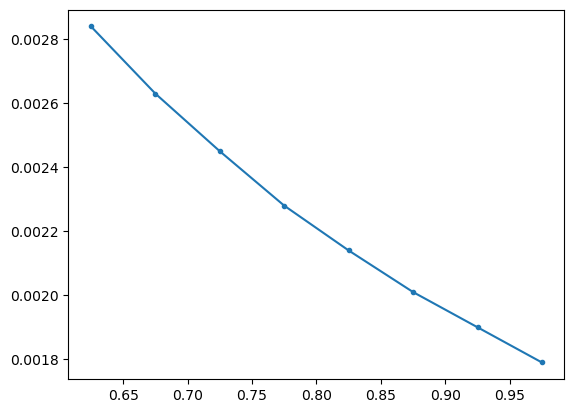

In [19]:
plt.plot(Zlist, W_dm_nl,'.-')

In [20]:
zmin=0.02
Zlist=[zmin+i/100 for i in range(220)]
W_dm_lin=[w_dm(z,typ='linear') for z in Zlist]
W_dm_NL=[w_dm(z,typ='NL') for z in Zlist]

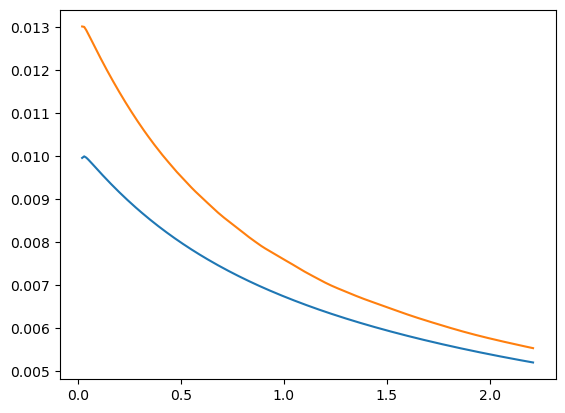

In [21]:
plt.plot(Zlist,W_dm_lin)
plt.plot(Zlist,W_dm_NL)

# 2-All these quantities are related to the DESY6 article: 

# $A_{mr}$, so clustering 

$A_{mr}=b_r \int dz K_m(z)n_r(z)\omega_{dm}(z)$


In [ ]:
#fiducial wdm:
w_dm_fid=interpolate.interp1d(Zlist,W_dm_NL)


In [ ]:
def Amr(br,Km,nr,z_n):
    zmin=z_n[0]
    zmax=z_n[-1]
    '''#if km and nr already interpolated
    zmin=Zlist[0]
    zmax=Zlist[-1]
    '''
    
    Km=interpolate.interp1d(z_n,Km)
    nr=interpolate.interp1d(z_n,nr)

    def Integ(z):
        return Km(z)*nr(z)*w_dm_fid(z)
        
    return br*quad(Integ,zmin, zmax,epsrel=10**(-6),epsabs=10**(-6),limit=nlim)[0]

# $D_{rm}$ magnification 

$D_{rm}=\frac{3 \Omega_m H_0}{c} \int_{z_r}\,dz_r\,\frac{H_0}{H(z_r)}\,n_r(z_r)\omega_{dm}(z_r) \chi_r(1+z_r)\,\int_{z_u>z_r}\,dz_u \, K_m(z_u)\frac{\chi_u-\chi_r}{\chi_u}$

In [ ]:
def Drm(Km,nr,z_n):
    zmin=z_n[0]
    zmax=z_n[-1]
    '''#if km and nr already interpolated
    zmin=Zlist[0]
    zmax=Zlist[-1]
    '''
    Km=interpolate.interp1d(z_n,Km)
    nr=interpolate.interp1d(z_n,nr)
    
    def Integ_r(zr):
        #The integral over unknown u
        def Integ_u(zu):
            return Km(zu)*(chi(zu)-chi(zr))/chi(zu)
        # we integrate from zr to zmax
        Hzr=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+zr))
        return H0/Hzr*nr(zr)*w_dm_fid(zr)*(1+zr)*chi(zr)*quad(Integ_u,zr, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=nlim)[0]
    # cst times the integral over reference r
    return 3*Omega_m*H0/c_ls*quad(Integ_r,zmin, zmax,epsrel=10**(-3),epsabs=10**(-6),limit=nlim)[0]
        

# $D_{um}$ magnification 

$D_{um}=\frac{3 \Omega_m H_0}{c} \int_{z_u}\,dz_u\,\frac{H_0}{H(z_u)}\,K_m(z_u)\omega_{dm}(z_u) \chi_u(1+z_u)\,\int_{z_r>z_u}\,dz_r \, n_r(z_r)\frac{\chi_r-\chi_u}{\chi_r}$




In [ ]:
def Dum(Km,nr,z_n):
    zmin=z_n[0]
    zmax=z_n[-1]
    '''#if km and nr already interpolated
    zmin=Zlist[0]
    zmax=Zlist[-1]
    '''
    Km=interpolate.interp1d(z_n,Km)
    nr=interpolate.interp1d(z_n,nr)
    
    def Integ_u(zu):
        #The integral over unknown u
        def Integ_r(zr):
            return nr(zr)*(chi(zr)-chi(zu))/chi(zr)
        # we integrate from zr to zmax
        Hzu=100*h*ccl.background.h_over_h0(cosmo,a=1/(1+zu))
        return H0/Hzu*Km(zu)*w_dm_fid(zu)*(1+zu)*chi(zu)*quad(Integ_r,zu, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=nlim)[0]
    # cst times the integral over reference r
    return 3*Omega_m*H0/c_ls*quad(Integ_u,zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=nlim)[0]
        

## Many more plots and test

In [12]:
Ztest=[0.1+i*0.1 for i in range(10)]
Rp=np.logspace(-1,1, 20)

XI_NL=[[ round(xi_dm_test(rp,z, 'NL'),4) for rp in Rp] for z in Ztest]
XI_lin=[[ round(xi_dm_test(rp,z, 'linear'),4) for rp in Rp] for z in Ztest]


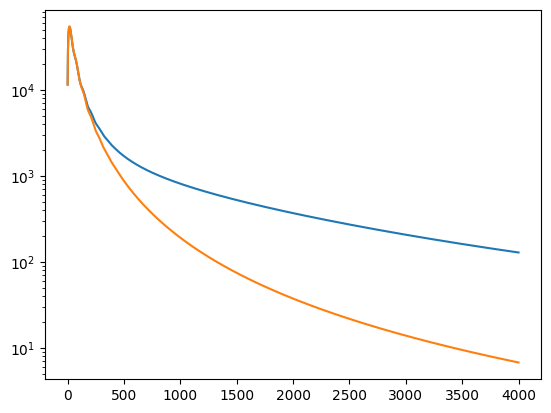

In [12]:
Ell=range(1,4000)
PNL_ell=[PNL(l,0.4) for l in Ell]
Plin_ell=[Plin(l,0.4) for l in Ell]
plt.plot(Ell,PNL_ell,label='NL z=0.5')
plt.plot(Ell,Plin_ell,label='linear z=0.5')
plt.yscale('log')

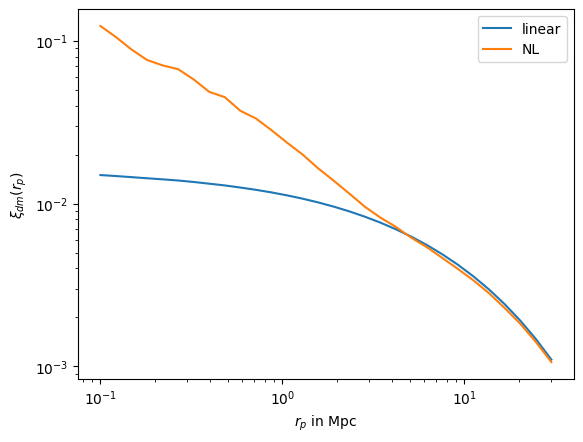

In [13]:
Rp=np.logspace(-1,np.log10(30),30)
XI_lin=[xi_dm_test(rp,0.5, typ='linear') for rp in Rp]
XI_NL=[xi_dm_test(rp,0.5, typ='NL') for rp in Rp]
plt.plot(Rp,XI_lin,label='linear')
plt.plot(Rp,XI_NL,label='NL')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$r_p$ in Mpc')
plt.ylabel(r'$\xi_{dm}(r_p)$')
plt.legend()

In [16]:
Zlist1=[0.01+i/10 for i in range(10)]
W_dm_lin1=[w_dm(z,typ='linear') for z in Zlist1]
W_dm_NL1=[w_dm(z,typ='NL') for z in Zlist1]

In [ ]:
# Test magnification

Nr=[[np.exp(-0.5*(z-0.1*i)**2/0.1**2)/0.1/np.sqrt(2*math.pi) for z in Zlist] for i in range(1,11)]

Clust=np.zeros((10,10))
M1=np.zeros((10,10))
M2=np.zeros((10,10))

for i in range(10):
    print(i)
    for j in range(10):
        Clust[i][j]=Amr(1,Nr[i],Nr[j],Zlist)
        M1[i][j]=Drm(Nr[i],Nr[j],Zlist)
        M2[i][j]=Dum(Nr[i],Nr[j],Zlist)


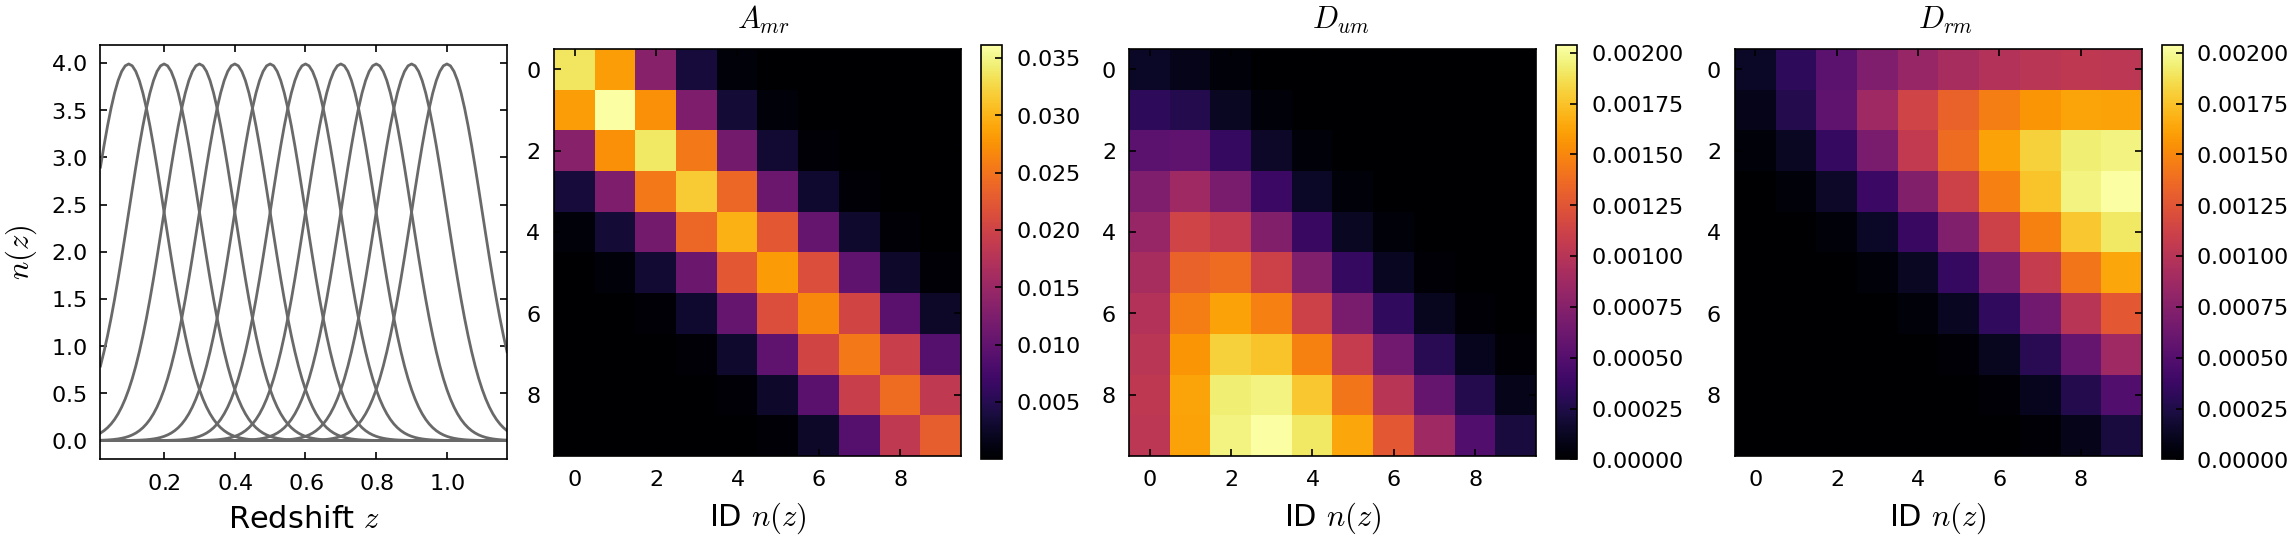

In [52]:
import niceplots.utils as nicepl
# Setting niceplot default settings
nicepl.initPlot()

plt.style.use('/nfs/pic.es/user/w/wdassign/codes_FS2/niceplots/niceplots/euclid_stylesheet_v1.mplstyle')


#plt.rcParams['figure.figsize'] = (8.9 / 2.54, 4/6*8.9 / 2.54)

plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = 'cmr10' # Set the font family to use outside mathtext expressions
plt.rcParams['mathtext.fontset'] = 'cm' # Font to use inside mathtext expresions
plt.rcParams["axes.formatter.use_mathtext"] = True # Use mathtext in the ticks of the axes

#rcParams['font.family'] = 'serif'
#rcParams['font.sans-serif'] = ['century']
#rcParams['figure.figsize'] = 14, 6
# Créez une figure

#fig, ax = plt.subplots(1,3,dpi=400,figsize=(14,6))
# Définissez les limites de l'axe x et y

fw, fh=plt.rcParams['figure.figsize'] # Get figure width and height

fig = plt.figure(constrained_layout=True, figsize=(2*1.6*fw*0.9, 2*0.5*fh*0.9))
gs = fig.add_gridspec( 1,4)
ax = np.array([[fig.add_subplot(gs[0]), fig.add_subplot(gs[1])],[fig.add_subplot(gs[2]), fig.add_subplot(gs[3])]])

for a in ax:
    for a1 in a:
        a1.tick_params(direction="in", top=True, right=True, zorder=10)

#plt.rcParams['figure.figsize'] = 10, 10
#fig, ax = plt.subplots(2,1,dpi=200)


for i in range(10):
    ax[0,0].plot(Zlist,Nr[i],color='dimgrey')

im1 = ax[0,1].imshow(Clust, cmap='inferno')
im2 = ax[1,0].imshow(M1, cmap='inferno')
im3 = ax[1,1].imshow(M2, cmap='inferno')

# Ajout des colorbars pour les sous-plots spécifiés
fig.colorbar(im1, ax=ax[0,1])
fig.colorbar(im2, ax=ax[1,0])
fig.colorbar(im3, ax=ax[1,1])

#ax[0,1].title('$A_{mr}$')
#ax[1,1].title('$D_{um}$')
#ax[1,0].title('$D_{rm}$')

ax[0,0].set_xlabel('Redshift $z$',fontsize=11)
ax[0,1].set_xlabel('ID $n(z)$',fontsize=11)
ax[1,0].set_xlabel('ID $n(z)$',fontsize=11)
ax[1,1].set_xlabel('ID $n(z)$',fontsize=11)
ax[0,0].set_ylabel('$n(z)$',fontsize=11)

ax[0,1].text(4,-1,'$A_{mr}$',fontsize=11)
ax[1,1].text(4,-1,'$D_{rm}$',fontsize=11)
ax[1,0].text(4,-1,'$D_{um}$',fontsize=11)

plt.savefig('Test_Gary_functions.pdf',bbox_inches='tight')

### Save and read

In [ ]:
import pickle 

fichier_pickle = "Test_A_D.pickle"

# Écriture des données dans le fichier pickle
donnees = {
    'z list wdm and nz': Zlist,
    'wdm_NL (the one I use)': W_dm_NL,
    'wdm_linearP': W_dm_lin,
    'nz_test':Nr,
    'Amr':Clust,
    'Drm':M1,
    'Dum':M2
}


with open(fichier_pickle, 'wb') as fichier:
    pickle.dump(donnees, fichier)
    

In [ ]:
import pickle

# Nom du fichier pickle
fichier_pickle = "Test_A_D.pickle"

# Lecture des données depuis le fichier pickle et sauvegarde dans des variables
try:
    with open(fichier_pickle, 'rb') as fichier:
        donnees = pickle.load(fichier)
    
    # Sauvegarde dans des variables individuelles
    Zlist = donnees.get('z list wdm and nz', None)
    W_dm_NL = donnees.get('wdm_NL (the one I use)', None)
    W_dm_lin = donnees.get('wdm_linearP', None)
    Nr = donnees.get('nz_test', None)
    Clust = donnees.get('Amr', None)
    M1 = donnees.get('Drm', None)
    M2 = donnees.get('Dum', None)
except FileNotFoundError:
    print(f"Le fichier {fichier_pickle} n'existe pas.")
except pickle.UnpicklingError:
    print("Erreur lors de la lecture des données du fichier pickle.")
